### Multiple linear regression


* The dependent variable must be continuous, while predictors can be continuous or categorical
* Each feature must exhibit a linear relationship with the dependent variable
* Minimize collinearity among features
* Residuals should follow a normal distribution

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

[data source & description](https://aegis4048.github.io/mutiple_linear_regression_and_visualization_in_python)

In [2]:
df = pd.read_csv("conv.csv")
df.head(1)

,Por,Perm,AI,Brittle,TOC,VR,Prod
0,12.08,2.92,2.8,81.4,1.16,2.31,4165.196191


<Axes: label='N', xlabel='Prod', ylabel='Density'>

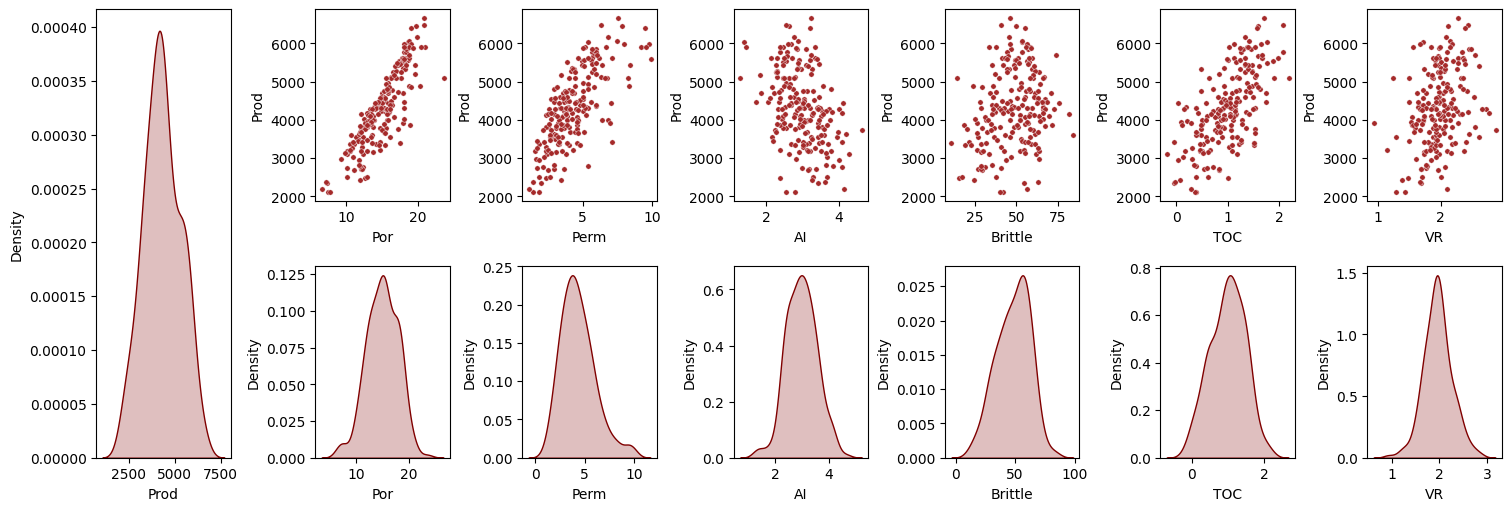

In [3]:
axd = plt.figure(constrained_layout=True, figsize=(15,5)).subplot_mosaic(
    """
    NABCDEF
    NGHIJKL
    """
)
sns.scatterplot(x=df['Por'], y=df['Prod'], s=15, color='brown', ax=axd['A'])
sns.scatterplot(x=df['Perm'], y=df['Prod'], s=15, color='brown', ax=axd['B'])
sns.scatterplot(x=df['AI'], y=df['Prod'], s=15, color='brown', ax=axd['C'])
sns.scatterplot(x=df['Brittle'], y=df['Prod'], s=15, color='brown', ax=axd['D'])
sns.scatterplot(x=df['TOC'], y=df['Prod'], s=15, color='brown', ax=axd['E'])
sns.scatterplot(x=df['VR'], y=df['Prod'], s=15, color='brown', ax=axd['F'])
sns.kdeplot(data=df, x='Por', fill=True, color='maroon', ax=axd['G'])
sns.kdeplot(data=df, x='Perm', fill=True, color='maroon', ax=axd['H'])
sns.kdeplot(data=df, x='AI', fill=True, color='maroon', ax=axd['I'])
sns.kdeplot(data=df, x='Brittle', fill=True, color='maroon', ax=axd['J'])
sns.kdeplot(data=df, x='TOC', fill=True, color='maroon', ax=axd['K'])
sns.kdeplot(data=df, x='VR', fill=True, color='maroon', ax=axd['L'])
sns.kdeplot(data=df, x='Prod', fill=True, color='maroon', ax=axd['N'])

#### detecting multicollinearity with vif

* VIF > 5 indicates high multicollinearity. remove features one at a time to minimize information loss. be cautious when removing a feature; it may impact model performance
* scaling can have a significant impact on the (VIF) 
* pearson's and spearman's correlation coefficients are pairwise measures and are not directly used to assess relationships among more than two variables simultaneously. Correlation measures how changes in one variable are associated with changes in another variable
* multicollinearity happens when high correlations between independent variables make it challenging to estimate their individual effects on the dependent variable. In such cases, individual regression coefficients become unreliable, but prediction on the dependent variable remains reliable
* to make reliable business decisions using linear regression coefficients, it's essential to mitigate the impact of multicollinearity

#### feature scaling

| aspect               | normalization (min-max sscaling) | standardization (z-score scaling) |
|----------------------|----------------------------------|----------------------------------|
| outlier sensitivity  | affected by outliers             | less affected by outliers        |
| feature range        | suitable when the range of features is within a particular range         | robust to variations in measurement units and differences in feature variances |
| data assumption      | no specific data distribution assumed | assumes data follows a normal distribution |


* if an algorithm isn't distance-based, feature scaling is generally unnecessary, e.g., Naive Bayes, Linear Discriminant Analysis, and Tree-Based models (gradient boosting, random forest, etc)
* algorithms have specific scaling requirements, e.g., logistic and linear regression require standardization; consult the documentation


In [4]:
X, y = df.drop(columns = ['Prod']), df['Prod']

In [5]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
scaled_df = pd.DataFrame(X_std, columns=X.columns)

In [6]:
vif = pd.DataFrame()
vif['feature'] = scaled_df.columns

vif['vif'] = [variance_inflation_factor(scaled_df.values, i) for i in range(len(scaled_df.columns))]
print(vif)

   feature       vif
0      Por  4.329838
1     Perm  2.862487
2       AI  7.660318
3  Brittle  2.165476
4      TOC  7.365773
5       VR  7.057671


In [7]:
X1 = X.drop(columns='AI')

#### Spearman's correlation

* robust to outliers and suitable for non-linear (monotonic) relationships or data that doesn't meet normality assumptions (than Pearson's)
* often advised to use unscaled (raw) data for accurate ranking and capturing monotonic relationships in analysis 
* |ρ| near 0 implies a weak or no relationship

In [8]:
corr_matrix = pd.DataFrame(columns=X1.columns, index=X1.columns)
for col1 in X1.columns:
    for col2 in X1.columns:
        if col1 != col2:
            correlation, _ = spearmanr(X1[col1], X[col2])
            corr_matrix.loc[col1, col2] = correlation

corr_matrix = corr_matrix.apply(pd.to_numeric, errors='coerce')
print(corr_matrix)

              Por      Perm   Brittle       TOC        VR
Por           NaN  0.769953 -0.209842  0.711007  0.159215
Perm     0.769953       NaN -0.092469  0.499674  0.106290
Brittle -0.209842 -0.092469       NaN -0.209476  0.254788
TOC      0.711007  0.499674 -0.209476       NaN  0.328057
VR       0.159215  0.106290  0.254788  0.328057       NaN


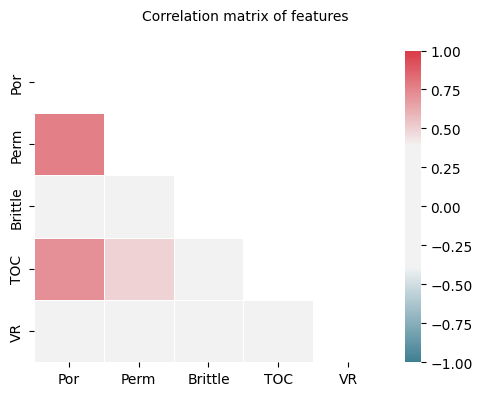

In [9]:
mask = np.zeros_like(corr_matrix, dtype=bool)  # Replace np.bool with bool
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(5, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)

fig.suptitle('Correlation matrix of features', fontsize=10)
# ax.text(0.77, 0.2, 'Your Name or Source', fontsize=13, ha='center', va='center', transform=ax.transAxes, color='grey', alpha=0.5)
fig.tight_layout()
plt.show()

c:\Users\samng\AppData\Local\Programs\Python\Python311\Lib\site-packages\rfpimp.py:52: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


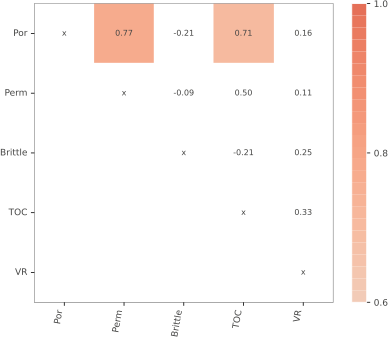

In [10]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(X1, figsize=(7,5))
# viz.save('../article/images/corrheatmap.svg')
viz

In [11]:
X2 = X1.drop(columns=['TOC','Perm'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=0)

<div class="alert alert-block alert-info" style="margin-top: 20px; color: blue;"> train a model using standardized data</div>


In [13]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('regr', LinearRegression())
])

In [44]:
pipe.fit(X_train,y_train)
y_pred1 = pipe.predict(X_test)

Pipeline(steps=[('scaler', StandardScaler()), ('regr', LinearRegression())])

#### evaluation

In [49]:
meanAbErr = metrics.mean_absolute_error(y_test, y_pred1)
meanSqErr = metrics.mean_squared_error(y_test, y_pred1)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred1))
r_squared = pipe.score(X2, y)

print('R-squared/coefficient of determination: {:.2f}'.format(r_squared * 100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R-squared/coefficient of determination: 93.92
Mean Absolute Error: 191.61475647137405
Mean Square Error: 69479.365565258
Root Mean Square Error: 263.58938818787453


#### extracting & reverting the coefficients to their original scale

In [58]:
regressor = pipe.named_steps['regr']
features = X2.columns
coef = list(zip(features, regressor.coef_))
coef_df =pd.DataFrame(coef, columns=['Feature', 'Coefficient'])
print ('Intercept: ',regressor.intercept_)
coef_df

Intercept:  4324.59159545


,Feature,Coefficient
0,Por,957.578056
1,Brittle,395.596846
2,VR,96.120200


In [59]:
regressor = pipe.named_steps['regr']
coefficients_standardized = regressor.coef_
intercept_standardized = regressor.intercept_
coefficients_original = coefficients_standardized / pipe.named_steps['scaler'].scale_

coef_df2 = pd.DataFrame({'Feature': X2.columns, 'Coefficient (Original Scale)': coefficients_original})
print('Intercept (Original Scale):', intercept_standardized - (coefficients_original * pipe.named_steps['scaler'].mean_).sum())
coef_df2

Intercept (Original Scale): -2436.136735417331


,Feature,Coefficient (Original Scale)
0,Por,316.485113
1,Brittle,28.835957
2,VR,316.265787


<div class="alert alert-block alert-danger">train a model on raw (unstandardized) data</div>

In [61]:
regressor = LinearRegression() 
regressor.fit(X_train, y_train)

LinearRegression()

In [62]:
features = df.columns
coef = list(zip(features, regressor.coef_))
coef_df =pd.DataFrame(coef, columns=['Feature', 'Coefficient'])
print ('Intercept: ',regressor.intercept_)
coef_df

Intercept:  -2436.13673541733


,Feature,Coefficient
0,Por,316.485113
1,Perm,28.835957
2,AI,316.265787


In [63]:
y_pred = regressor.predict(X_test)

meanAbErr = metrics.mean_absolute_error(y_test, y_pred)
meanSqErr = metrics.mean_squared_error(y_test, y_pred)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('R squared/coefficient of determination: {:.2f}'.format(regressor.score(X2,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared/coefficient of determination: 93.92
Mean Absolute Error: 191.61475647137408
Mean Square Error: 69479.36556525799
Root Mean Square Error: 263.5893881878745


#### residual plot

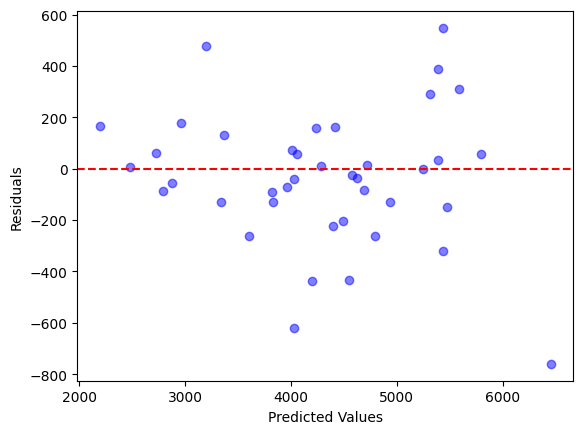

In [64]:
residuals = y_test - y_pred

# Create a scatter plot of residuals
plt.scatter(y_pred, residuals, c='blue', marker='o', alpha=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.show()

#### linear regression using statsmodels

In [66]:
x_int = sm.add_constant(X_train)

model = sm.OLS(y_train,x_int).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   Prod   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     839.9
Date:                Sat, 09 Sep 2023   Prob (F-statistic):           5.15e-96
Time:                        03:29:11   Log-Likelihood:                -1103.2
No. Observations:                 160   AIC:                             2214.
Df Residuals:                     156   BIC:                             2227.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2436.1367    164.046    -14.850      0.0